In [20]:
import rasterio
from rasterio import features
from rasterio.windows import Window
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Paths
ortho_path = '../data/images/28996_NADALA_ORTHO.tif'
road_shp_path = '../data/shp/Road.shp'

print("Libraries loaded.")

Libraries loaded.


In [21]:
def rasterize_roads(tif_path, gdf):
    """
    Rasterizes road polygons into a binary mask aligned with the input GeoTIFF.
    
    Args:
        tif_path (str): Path to the orthophoto GeoTIFF
        gdf (GeoDataFrame): Road polygons (will be reprojected if needed)
        
    Returns:
        tuple: (mask_array, src_dataset)
            mask_array: uint8 numpy array (1=road, 0=background)
            src_dataset: rasterio dataset reader (open)
    """
    # 1. Open Source Image
    src = rasterio.open(tif_path)
    print(f"Correctly opened: {tif_path}")
    print(f"Image Profile: {src.width}x{src.height}, CRS={src.crs}")
    
    # 2. Align CRS
    if gdf.crs != src.crs:
        print(f"Reprojecting vectors from {gdf.crs} to {src.crs}...")
        gdf = gdf.to_crs(src.crs)
    else:
        print("CRS Aligned.")
        
    # 3. Rasterize
    # Burn geometry into a zero-filled array matching image shape
    # value=1 for roads, fill=0 for background
    print("Rasterizing... (this may take a few seconds)")
    mask = features.rasterize(
        shapes=((geom, 1) for geom in gdf.geometry),
        out_shape=src.shape,
        transform=src.transform,
        fill=0,
        default_value=1,
        dtype=rasterio.uint8
    )
    print("Rasterization complete.")
    
    return mask, src

In [22]:
def visualize_verification(src, mask, window_size=2048):
    """
    Extracts and plots a window to verify alignment.
    """
    # Center window
    cx, cy = src.width // 2, src.height // 2
    col_off = max(0, min(cx - window_size // 2, src.width - window_size))
    row_off = max(0, min(cy - window_size // 2, src.height - window_size))
    
    window = Window(col_off, row_off, window_size, window_size)
    print(f"\nExtracting window: {window}")
    
    # Read data
    img_tile = src.read(window=window)
    mask_tile = mask[row_off:row_off+window_size, col_off:col_off+window_size]
    
    # Stats
    road_px = np.count_nonzero(mask_tile)
    total_px = mask_tile.size
    print(f"Unique Mask Values: {np.unique(mask_tile)}")
    print(f"Road Coverage in Tile: {road_px / total_px * 100:.2f}%")
    
    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. RGB Image (transpose to HWC)
    ax[0].imshow(np.moveaxis(img_tile, 0, -1))
    ax[0].set_title("Orthophoto (RGB)")
    ax[0].axis('off')
    
    # 2. Mask
    ax[1].imshow(mask_tile, cmap='gray')
    ax[1].set_title("Road Binary Mask")
    ax[1].axis('off')
    
    # 3. Overlay
    ax[2].imshow(np.moveaxis(img_tile, 0, -1))
    # Mask overlay (Red)
    overlay = np.zeros((*mask_tile.shape, 4))
    overlay[mask_tile == 1] = [1, 0, 0, 0.5]  # Red with 50% alpha
    ax[2].imshow(overlay)
    ax[2].set_title("Overlay")
    ax[2].axis('off')
    
    plt.show()

Correctly opened: ../data/images/28996_NADALA_ORTHO.tif
Image Profile: 26259x27390, CRS=EPSG:32643
Reprojecting vectors from EPSG:3857 to EPSG:32643...
Rasterizing... (this may take a few seconds)
Rasterization complete.

Extracting window: Window(col_off=12105, row_off=12671, width=2048, height=2048)
Unique Mask Values: [0 1]
Road Coverage in Tile: 1.50%


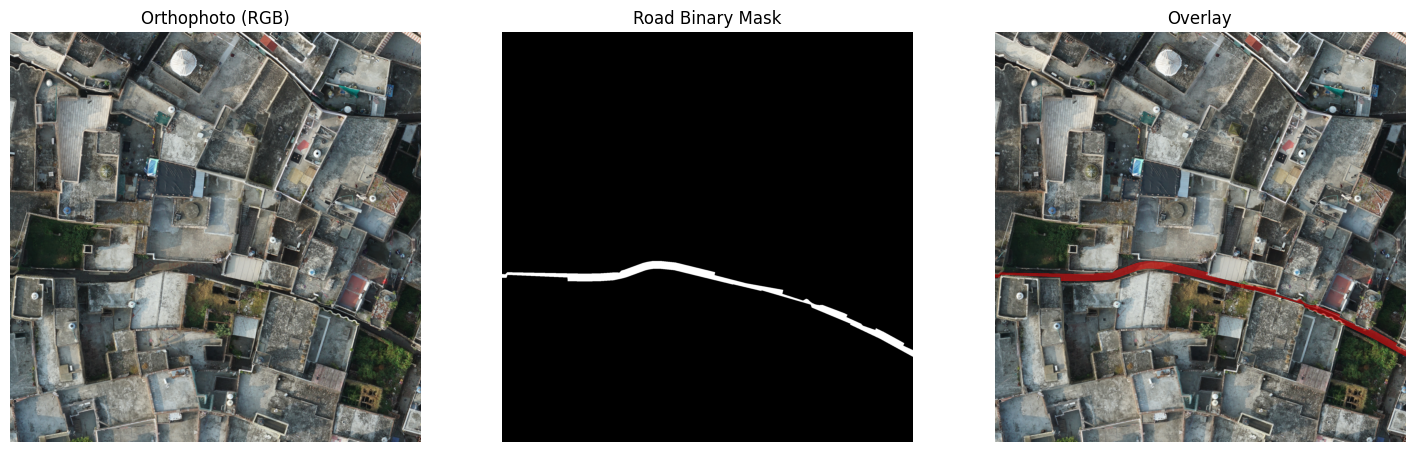

In [23]:
# Load GeoDataFrame once
road_gdf = gpd.read_file(road_shp_path)

# Run Pipeline
road_mask, src = rasterize_roads(ortho_path, road_gdf)

# Viz
visualize_verification(src, road_mask)

In [24]:
import os
from tqdm import tqdm

# Configuration
TILE_SIZE = 512
OVERLAP = 128
THRESHOLD = 0.01 # 1%
OUTPUT_BASE = '../data/tiles'
IMG_DIR = os.path.join(OUTPUT_BASE, 'images')
MASK_DIR = os.path.join(OUTPUT_BASE, 'masks')

# Create directories
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(MASK_DIR, exist_ok=True)
print(f"Directories created:\n{IMG_DIR}\n{MASK_DIR}")

Directories created:
../data/tiles/images
../data/tiles/masks


In [25]:
def generate_training_data(src_dataset, full_mask):
    """
    Tiles image and mask, filters by content, and saves as .npy.
    """
    stride = TILE_SIZE - OVERLAP
    w, h = src_dataset.width, src_dataset.height
    
    count = 0
    
    print(f"Starting tiling process (Size={TILE_SIZE}, Overlap={OVERLAP})...")
    
    # Iterate with sliding window
    for row in tqdm(range(0, h - TILE_SIZE + 1, stride)):
        for col in range(0, w - TILE_SIZE + 1, stride):
            # Extract Mask Tile First (Memory)
            mask_tile = full_mask[row:row+TILE_SIZE, col:col+TILE_SIZE]
            
            # Filter: Check road content
            if np.count_nonzero(mask_tile) / mask_tile.size < THRESHOLD:
                continue
                
            # Extract Image Tile (Read from Disk via Window)
            window = Window(col, row, TILE_SIZE, TILE_SIZE)
            img_tile = src_dataset.read(window=window) # Shape (C, H, W)
            
            # Save
            # Images are saved as (C, H, W) consistent with rasterio read
            np.save(os.path.join(IMG_DIR, f"tile_{count}.npy"), img_tile)
            np.save(os.path.join(MASK_DIR, f"tile_{count}.npy"), mask_tile)
            
            count += 1
            
    print(f"Processing complete. Saved {count} valid tiles.")
    return count

In [26]:
# Execute tiling
total_tiles = generate_training_data(src, road_mask)
print(f"Total tiles generated: {total_tiles}")

Starting tiling process (Size=512, Overlap=128)...


100%|██████████| 70/70 [00:16<00:00,  4.13it/s]

Processing complete. Saved 1274 valid tiles.
Total tiles generated: 1274


Tile 0 Shape: Img=(4, 512, 512), Mask=(512, 512)


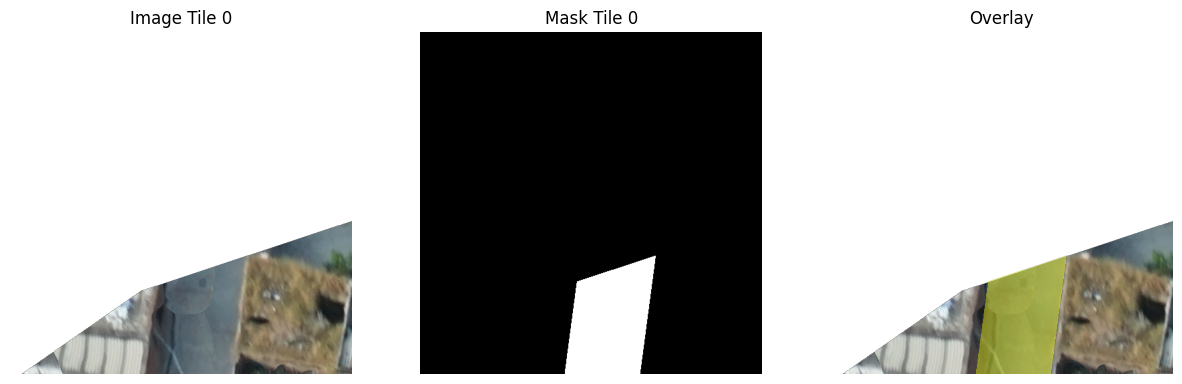

In [27]:
def visualize_sample_tile(idx=0):
    img_path = os.path.join(IMG_DIR, f"tile_{idx}.npy")
    mask_path = os.path.join(MASK_DIR, f"tile_{idx}.npy")
    
    if not os.path.exists(img_path):
        print(f"Tile {idx} not found.")
        return

    img = np.load(img_path)
    mask = np.load(mask_path)
    
    print(f"Tile {idx} Shape: Img={img.shape}, Mask={mask.shape}")
    
    # Rasterio reads as (C, H, W), matplotlib needs (H, W, C)
    if img.shape[0] <= 4: 
        img_show = np.moveaxis(img, 0, -1)
    else:
        img_show = img
        
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img_show)
    ax[0].set_title(f"Image Tile {idx}")
    ax[0].axis('off')
    
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title(f"Mask Tile {idx}")
    ax[1].axis('off')
    
    ax[2].imshow(img_show)
    # Overlay in Yellow
    overlay = np.zeros((*mask.shape, 4))
    overlay[mask == 1] = [1, 1, 0, 0.4]
    ax[2].imshow(overlay)
    ax[2].set_title("Overlay")
    ax[2].axis('off')
    
    plt.show()

if total_tiles > 0:
    visualize_sample_tile(0)

In [28]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class RoadDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        # Simple list of filenames (assumes alignment)
        self.files = sorted([f for f in os.listdir(image_dir) if f.endswith('.npy')])
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.files[idx])
        mask_path = os.path.join(self.mask_dir, self.files[idx])
        
        # Load and Normalize (0-1)
        image = np.load(img_path).astype(np.float32) / 255.0 
        # Handle channels (Keep RGB only if 4 channels)
        if image.shape[0] > 3:
            image = image[:3, :, :]
            
        mask = np.load(mask_path).astype(np.float32)         
        
        # Ensure mask has channel dim (1, H, W)
        if len(mask.shape) == 2:
            mask = np.expand_dims(mask, axis=0) 
            
        return torch.from_numpy(image), torch.from_numpy(mask)

# Create Dataset and Loader
train_ds = RoadDataset(IMG_DIR, MASK_DIR)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4)
print(f"Training data loaded: {len(train_ds)} tiles")

Using device: cuda
Training data loaded: 1274 tiles


In [29]:
# U-Net with ResNet34 Encoder Implementation using Torchvision
# This avoids external dependencies like segmentation_models_pytorch for robustness

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, inputs):
        x = self.relu(self.bn1(self.conv1(inputs)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x
        
class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = ConvBlock(out_c + out_c, out_c)
        
    def forward(self, inputs, skip):
        x = self.up(inputs)
        # Handle slight shape mismatches if any
        if x.shape != skip.shape:
            x = torch.nn.functional.interpolate(x, size=skip.shape[2:])
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

class ResNet34UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: Pretrained ResNet34
        resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        
        # Layers for skip connections
        self.enc1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu) # 64 channels
        self.enc2 = nn.Sequential(resnet.maxpool, resnet.layer1)         # 64 channels
        self.enc3 = resnet.layer2                                      # 128 channels
        self.enc4 = resnet.layer3                                      # 256 channels
        self.bridge = resnet.layer4                                    # 512 channels
        
        # Decoder
        self.dec1 = DecoderBlock(512, 256) # In: 512, Skip: 256 -> Out: 256
        self.dec2 = DecoderBlock(256, 128) # In: 256, Skip: 128 -> Out: 128
        self.dec3 = DecoderBlock(128, 64)  # In: 128, Skip: 64  -> Out: 64
        self.dec4 = DecoderBlock(64, 64)   # In: 64,  Skip: 64  -> Out: 64
        
        # Final layers to restore resolution (256x256 -> 512x512)
        self.final_up = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.final = nn.Conv2d(32, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Encoder
        s1 = self.enc1(x)
        s2 = self.enc2(s1)
        s3 = self.enc3(s2)
        s4 = self.enc4(s3)
        b = self.bridge(s4)
        
        # Decoder
        d1 = self.dec1(b, s4)
        d2 = self.dec2(d1, s3)
        d3 = self.dec3(d2, s2)
        d4 = self.dec4(d3, s1)
        
        # Final Upsample
        x = self.final_up(d4)
        outputs = self.final(x)
        return self.sigmoid(outputs)

# Initialize Model
model = ResNet34UNet().to(device)
print("Model initialized: ResNet34-UNet (Custom Implementation)")

Model initialized: ResNet34-UNet (Custom Implementation)


In [30]:
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceBCELoss, self).__init__()
        self.smooth = smooth
        self.bce = nn.BCELoss()

    def forward(self, inputs, targets):
        # Flatten for Dice
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (inputs_flat.sum() + targets_flat.sum() + self.smooth)
        
        bce_loss = self.bce(inputs, targets)
        
        return bce_loss + dice_loss

def calculate_metrics(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    
    # IoU
    intersection = (pred_bin * target).sum()
    union = pred_bin.sum() + target.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    
    # Accuracy
    accuracy = (pred_bin == target).float().mean()
    
    return iou.item(), accuracy.item()

In [31]:
# Config
EPOCHS = 25
LR = 1e-4

criterion = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print(f"Starting training for {EPOCHS} epochs on {device}...")

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_iou = 0
    epoch_acc = 0
    
    # Training Loop
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        # Track Metrics
        iou, acc = calculate_metrics(outputs, masks)
        epoch_loss += loss.item()
        epoch_iou += iou
        epoch_acc += acc
        
    # Epoch Summary
    n_batches = len(train_loader)
    avg_loss = epoch_loss / n_batches
    avg_iou = epoch_iou / n_batches
    avg_acc = epoch_acc / n_batches
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f} | Acc: {avg_acc:.4f}")

# Save Model
model_save_path = '../models/road_unet.pth'
os.makedirs('../models', exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f"\nTraining Complete. Model saved to {model_save_path}")

Starting training for 25 epochs on cuda...
Epoch [1/25] Loss: 1.0714 | IoU: 0.5063 | Acc: 0.8381
Epoch [2/25] Loss: 0.5511 | IoU: 0.6951 | Acc: 0.9415
Epoch [3/25] Loss: 0.3276 | IoU: 0.7715 | Acc: 0.9601
Epoch [4/25] Loss: 0.2423 | IoU: 0.8128 | Acc: 0.9684
Epoch [5/25] Loss: 0.1983 | IoU: 0.8377 | Acc: 0.9733
Epoch [6/25] Loss: 0.1502 | IoU: 0.8710 | Acc: 0.9794
Epoch [7/25] Loss: 0.1185 | IoU: 0.8962 | Acc: 0.9835
Epoch [8/25] Loss: 0.0972 | IoU: 0.9132 | Acc: 0.9863
Epoch [9/25] Loss: 0.0916 | IoU: 0.9165 | Acc: 0.9870
Epoch [10/25] Loss: 0.0756 | IoU: 0.9302 | Acc: 0.9891
Epoch [11/25] Loss: 0.0692 | IoU: 0.9355 | Acc: 0.9900
Epoch [12/25] Loss: 0.0686 | IoU: 0.9353 | Acc: 0.9900
Epoch [13/25] Loss: 0.0609 | IoU: 0.9420 | Acc: 0.9911
Epoch [14/25] Loss: 0.0585 | IoU: 0.9439 | Acc: 0.9914
Epoch [15/25] Loss: 0.0534 | IoU: 0.9485 | Acc: 0.9921
Epoch [16/25] Loss: 0.0521 | IoU: 0.9506 | Acc: 0.9923
Epoch [17/25] Loss: 0.1438 | IoU: 0.8711 | Acc: 0.9791
Epoch [18/25] Loss: 0.0690 | Io

In [34]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import cv2
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from torchvision import transforms

# ----------------------------
# 1. Model Architecture Setup (MUST MATCH TRAINING EXACTLY)
# ----------------------------

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, inputs):
        x = self.relu(self.bn1(self.conv1(inputs)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x
        
class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = ConvBlock(out_c + out_c, out_c)
        
    def forward(self, inputs, skip):
        x = self.up(inputs)
        # Handle slight shape mismatches if any
        if x.shape != skip.shape:
            x = torch.nn.functional.interpolate(x, size=skip.shape[2:])
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

class ResNet34UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: Pretrained ResNet34
        resnet = models.resnet34(weights=None) # Start empty, we load weights
        
        # Layers for skip connections
        self.enc1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu) # 64 channels
        self.enc2 = nn.Sequential(resnet.maxpool, resnet.layer1)         # 64 channels
        self.enc3 = resnet.layer2                                      # 128 channels
        self.enc4 = resnet.layer3                                      # 256 channels
        self.bridge = resnet.layer4                                    # 512 channels
        
        # Decoder
        self.dec1 = DecoderBlock(512, 256) # In: 512, Skip: 256 -> Out: 256
        self.dec2 = DecoderBlock(256, 128) # In: 256, Skip: 128 -> Out: 128
        self.dec3 = DecoderBlock(128, 64)  # In: 128, Skip: 64  -> Out: 64
        self.dec4 = DecoderBlock(64, 64)   # In: 64,  Skip: 64  -> Out: 64
        
        # Final layers to restore resolution (256x256 -> 512x512)
        self.final_up = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.final = nn.Conv2d(32, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Encoder
        s1 = self.enc1(x)
        s2 = self.enc2(s1)
        s3 = self.enc3(s2)
        s4 = self.enc4(s3)
        b = self.bridge(s4)
        
        # Decoder
        d1 = self.dec1(b, s4)
        d2 = self.dec2(d1, s3)
        d3 = self.dec3(d2, s2)
        d4 = self.dec4(d3, s1)
        
        # Final Upsample
        x = self.final_up(d4)
        outputs = self.final(x)
        return self.sigmoid(outputs)

# Load Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet34UNet().to(device)
# Load weights - map_location helps if moving between GPU/CPU
model.load_state_dict(torch.load('../models/road_unet.pth', map_location=device))
model.eval()
print("Model loaded and ready for inference.")

Model loaded and ready for inference.


In [39]:
# ----------------------------
# 2. Processing Functions
# ----------------------------

def predict_large_tile(model, large_image, patch_size=512, stride=256, device='cuda'):
    """
    Runs sliding window inference on a large image tile.
    Averages predictions in overlapping regions for smoothness.
    """
    # Handle 4-channel inputs (keep RGB)
    if large_image.shape[-1] > 3:
        large_image = large_image[:, :, :3]

    h, w = large_image.shape[:2]
    
    # Normalize
    img_tensor = large_image.astype(np.float32) / 255.0
    img_tensor = np.transpose(img_tensor, (2, 0, 1)) # HWC -> CHW
    img_tensor = torch.from_numpy(img_tensor)
    
    # Prepare probability map and count map for averaging
    prob_map = torch.zeros((1, h, w)).to(device)
    count_map = torch.zeros((1, h, w)).to(device)
    
    with torch.no_grad():
        for y in range(0, h, stride):
            for x in range(0, w, stride):
                # Calculate window
                y_end, x_end = min(y + patch_size, h), min(x + patch_size, w)
                y_start = y_end - patch_size
                x_start = x_end - patch_size
                
                # Extract patch
                patch = img_tensor[:, y_start:y_end, x_start:x_end].unsqueeze(0).to(device)
                
                # Predict
                preds = model(patch)
                
                # Accumulate
                prob_map[:, y_start:y_end, x_start:x_end] += preds.squeeze(0)
                count_map[:, y_start:y_end, x_start:x_end] += 1

    # Average and return to CPU numpy
    avg_probs = (prob_map / count_map).cpu().numpy().squeeze()
    return avg_probs
def post_process_mask(probability_map, threshold=0.3): # Lower threshold often helps with continuity
    """
    Applies thresholding, morphological closing, and skeletonization.
    """
    # 1. Threshold
    binary_mask = (probability_map > threshold).astype(np.uint8)
    
    # 2. Morphological Closing (Fill small gaps/holes)
    # Kernel size 5 is good for ~50cm resolution roads
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    
    # Remove small noise (optional)
    # num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed_mask, connectivity=8)
    # min_size = 500 
    # for i in range(1, num_labels):
    #     if stats[i, cv2.CC_STAT_AREA] < min_size:
    #         closed_mask[labels == i] = 0

    # 3. Skeletonize (Extract Centerlines)
    # Skeletonize expects boolean or 0/1 float, returns boolean
    skeleton = skeletonize(closed_mask)
    
    return binary_mask, closed_mask, skeleton

In [40]:
# ----------------------------
# 3. Execution Pipeline
# ----------------------------

# Define source path
ORTHO_PATH = '../data/images/28996_NADALA_ORTHO.tif'

# Define Window (Center crop 2048x2048)
WINDOW_SIZE = 2048
with rasterio.open(ORTHO_PATH) as src:
    # Pick center coords
    c_col, c_row = src.width // 2, src.height // 2
    col_off = c_col - (WINDOW_SIZE // 2)
    row_off = c_row - (WINDOW_SIZE // 2)
    
    window = Window(col_off, row_off, WINDOW_SIZE, WINDOW_SIZE)
    
    # Read Image (C, H, W)
    img_data = src.read(window=window)
    # Convert to (H, W, C) for plotting and processing
    img_rgb = np.moveaxis(img_data, 0, -1)

print(f"Extracted Tile Shape: {img_rgb.shape}")

# Run Inference
print("Running Inference...")
raw_probs = predict_large_tile(model, img_rgb, patch_size=512, stride=256, device=device)

# Post Processing
print("Post-processing...")
bin_mask, clean_mask, road_skeleton = post_process_mask(raw_probs)

print("Processing Complete.")

Extracted Tile Shape: (2048, 2048, 4)
Running Inference...
Post-processing...
Processing Complete.


# Testing

In [1]:
import torch
import rasterio
import numpy as np
import cv2
from rasterio.windows import Window
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [4]:
from models.unet import UNet  # or wherever your UNet class is

model = UNet(in_channels=3, out_channels=1)
model.load_state_dict(torch.load("models/road_unet.pth", map_location=device))
model = model.to(device)
model.eval()

print("Model loaded successfully")


Model loaded successfully


In [5]:
def normalize_uint8(img):
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-6)
    return img


In [15]:
tif_path = "data/live_demo_2/ANAITPURA_FATEHGARH_SAHIB_32705_ORTHO/ANAITPURA_FATEHGARH SAHIB_32705_ORTHO.tif"


In [16]:
tile_size = 2048
stride = 2048  # no overlap for now (fast)

with rasterio.open(tif_path) as src:
    H, W = src.height, src.width
    transform = src.transform
    crs = src.crs

    final_mask = np.zeros((H, W), dtype=np.uint8)

    for y in tqdm(range(0, H, stride)):
        for x in range(0, W, stride):
            window = Window(
                x, y,
                min(tile_size, W - x),
                min(tile_size, H - y)
            )

            tile = src.read([1,2,3], window=window)  # RGB
            tile = np.transpose(tile, (1,2,0))

            if tile.shape[0] < tile_size or tile.shape[1] < tile_size:
                continue  # skip partial tiles for now

            tile = normalize_uint8(tile)
            tile = torch.from_numpy(tile).permute(2,0,1).unsqueeze(0).to(device)

            with torch.no_grad():
                pred = model(tile)
                pred = torch.sigmoid(pred)
                pred = (pred > 0.5).cpu().numpy()[0,0]

            final_mask[y:y+tile_size, x:x+tile_size] = (pred * 255).astype(np.uint8)


100%|██████████| 13/13 [00:46<00:00,  3.60s/it]


In [18]:
out_path = "../outputs/road_mask_live_demo_2.tif"

with rasterio.open(
    out_path,
    "w",
    driver="GTiff",
    height=final_mask.shape[0],
    width=final_mask.shape[1],
    count=1,
    dtype="uint8",
    crs=crs,
    transform=transform,
) as dst:
    dst.write(final_mask, 1)

print("Saved:", out_path)


Saved: ../outputs/road_mask_live_demo_2.tif
